In [1]:
# prompt: Need help in deriving PCA for a dataset. I need sample code. Also, I would like to use the dataset LuFlow which is available in my Google Drive. I think I need to do data engineering on the dataset. Can you give the step by step example and the code accordingly?
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import seaborn as sns


In [2]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
%load_ext tensorboard

In [4]:
### To check whether GPU is used.
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU is available and being used.")
    print("GPU Details:", gpu_available)
else:
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


In [5]:
from IPython.display import Image
import os, datetime

In [6]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report,roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [7]:
from google.colab import drive
drive.mount('/content/drive')
# Define the file path to your dataset in Google Drive
#file_path = '/content/drive/MyDrive/LuFlow.csv'
#file_path = '/content/drive/MyDrive/VIT/Dataset/CIC-DDos2019/cic-ddos2019.csv'


Mounted at /content/drive


In [8]:
dfps_tr = []
dfps_ts = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/VIT/Dataset/NF-ToN-IoT-v2/'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_tr.append(dfp)
            print(dfp)

/content/drive/MyDrive/VIT/Dataset/NF-ToN-IoT-v2/NF-ToN-IoT-V2.parquet


In [9]:
df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_tr], ignore_index=True)


In [10]:
df.shape

(13135881, 43)

**Store these datasets in Google Drive as they can be used as starting point few use cases.**

In [11]:
def dropInfNull(df):
    print (df.shape)

    # replace infinity value as null value
    df = df.replace(["Infinity", "infinity"], np.inf)
    df = df.replace([np.inf, -np.inf], np.nan)

    # drop all null values
    df.dropna(inplace=True)

    print (df.shape)

    return df

In [12]:
%%time
network_data_d1 = dropInfNull(df)

(13135881, 43)
(13135881, 43)
CPU times: user 6.93 s, sys: 4.61 s, total: 11.5 s
Wall time: 14.8 s


In [13]:
# prompt: Can you give the code to display the feature names?

network_data_d1.columns

Index(['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES',
       'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS',
       'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN',
       'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT',
       'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN',
       'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'Label', 'Attack'],
      dtype='object')

I see that in NF-ToN-IoT-v2, there are 9.5 million malign data and 3.6M of benign data. Based on the protocols and their count and their malign levels, we can remove those datasets.

In [14]:
#Get the unique labels
unique_labels = network_data_d1['PROTOCOL'].unique()

#Get the counts of each unique label
label_counts = network_data_d1['PROTOCOL'].value_counts()

#Print the results

print("Unique Labels:")
print(unique_labels)

print("\nCounts of Each Label:")
print(label_counts)

Unique Labels:
[ 6  1 17  2 58 44]

Counts of Each Label:
PROTOCOL
6     10636455
17     2480255
1        15914
2         2015
58        1241
44           1
Name: count, dtype: int64


In [15]:
# Filter the DataFrame for rows where 'PROTOCOL' is 6 and 'Label' is 1 (malign)
malign_protocol_6_count = network_data_d1[(network_data_d1['PROTOCOL'] == 6) & (network_data_d1['Label'] == 1)].shape[0]

# Print the count
print(f"Count of malign data with PROTOCOL 6: {malign_protocol_6_count}")

Count of malign data with PROTOCOL 6: 7584590


In [16]:
network_data_d1.Attack.value_counts()

,count
Attack,
Benign,3601284
scanning,3002169
xss,2449955
ddos,1746590
password,993718
injection,660467
dos,654359
backdoor,16259
mitm,7723


In [17]:
# Filter data for 'Scanning'
cut_scan_df = network_data_d1[network_data_d1['Attack'] == 'scanning']
cut_xss_df =  network_data_d1[network_data_d1['Attack'] == 'xss']
cut_ddos_df =  network_data_d1[network_data_d1['Attack'] == 'ddos']
cut_pwd_df =  network_data_d1[network_data_d1['Attack'] == 'pwd']
cut_inj_df =  network_data_d1[network_data_d1['Attack'] == 'injection']
cut_dos_df =  network_data_d1[network_data_d1['Attack'] == 'dos']
cut_backdoor_df =  network_data_d1[network_data_d1['Attack'] == 'backdoor']
cut_mitm_df =  network_data_d1[network_data_d1['Attack'] == 'mitm']
cut_rans_df =  network_data_d1[network_data_d1['Attack'] == 'ransomware']
cut_benign_df =  network_data_d1[network_data_d1['Attack'] == 'Benign']

In [31]:
# Sample 20% of 'scanning' data (to keep)
scan_to_keep = cut_scan_df.sample(frac=0.03, random_state=42)
xss_to_keep = cut_xss_df.sample(frac=0.03, random_state=42)
ddos_to_keep = cut_ddos_df.sample(frac=0.03, random_state=42)
pwd_to_keep = cut_pwd_df.sample(frac=0.05, random_state=42)
inj_to_keep = cut_inj_df.sample(frac=0.15, random_state=42)
dos_to_keep = cut_dos_df.sample(frac=0.03, random_state=42)
benign_to_keep = cut_benign_df.sample(frac=0.10, random_state=42)

In [32]:
# Combine the data to keep
df_reduced = pd.concat([scan_to_keep, xss_to_keep, ddos_to_keep, pwd_to_keep, inj_to_keep, dos_to_keep, cut_backdoor_df, cut_mitm_df, cut_rans_df, benign_to_keep])

In [33]:
#Get the unique labels
unique_labels = df_reduced['Label'].unique()

#Get the counts of each unique label
label_counts = df_reduced['Label'].value_counts()

#Print the results

print("Unique Labels:")
print(unique_labels)

print("\nCounts of Each Label:")
print(label_counts)

Unique Labels:
[1 0]

Counts of Each Label:
Label
1    362002
0    360128
Name: count, dtype: int64


In [34]:
# prompt: Write a code to save this dataframe df_reduced in Google Drive location - "'/content/drive/MyDrive/VIT/Dataset/CIC-DDos2019/" in the file - cic-ddos2019-parquet-preprocessed.csv

# Define the full file path
output_file_path = '/content/drive/MyDrive/VIT/Dataset/NF-ToN-IoT-v2/nf_ton_iotv2-preprocessed.csv'

# Save the DataFrame to a CSV file
df_reduced.to_csv(output_file_path, index=False)

print(f"DataFrame successfully saved to {output_file_path}")

DataFrame successfully saved to /content/drive/MyDrive/VIT/Dataset/NF-ToN-IoT-v2/nf_ton_iotv2-preprocessed.csv


**Drop Constant Column**

In [35]:
%%time
# drop the constant columns (which varience is 0)
variances = df_reduced.var(numeric_only=True)
constant_columns = variances[variances == 0].index
df_balanced = df_reduced.drop(constant_columns, axis=1)

print(constant_columns)
print (df_balanced.shape)

Index([], dtype='object')
(722130, 43)
CPU times: user 230 ms, sys: 1.36 ms, total: 232 ms
Wall time: 235 ms


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


**Drop Duplicate Column**

In [37]:
duplicates = set()
for i in range(0, len(df_balanced.columns)):
    col1 = df_balanced.columns[i]
    for j in range(i+1, len(df_balanced.columns)):
        col2 = df_balanced.columns[j]
        if(df_balanced[col1].equals(df_balanced[col2])):
            duplicates.add(col2)

print (duplicates)
df_balanced.drop(duplicates, axis=1, inplace=True)
print (df_balanced.shape)

set()
(722130, 42)


**Drop Columns based on correlation**

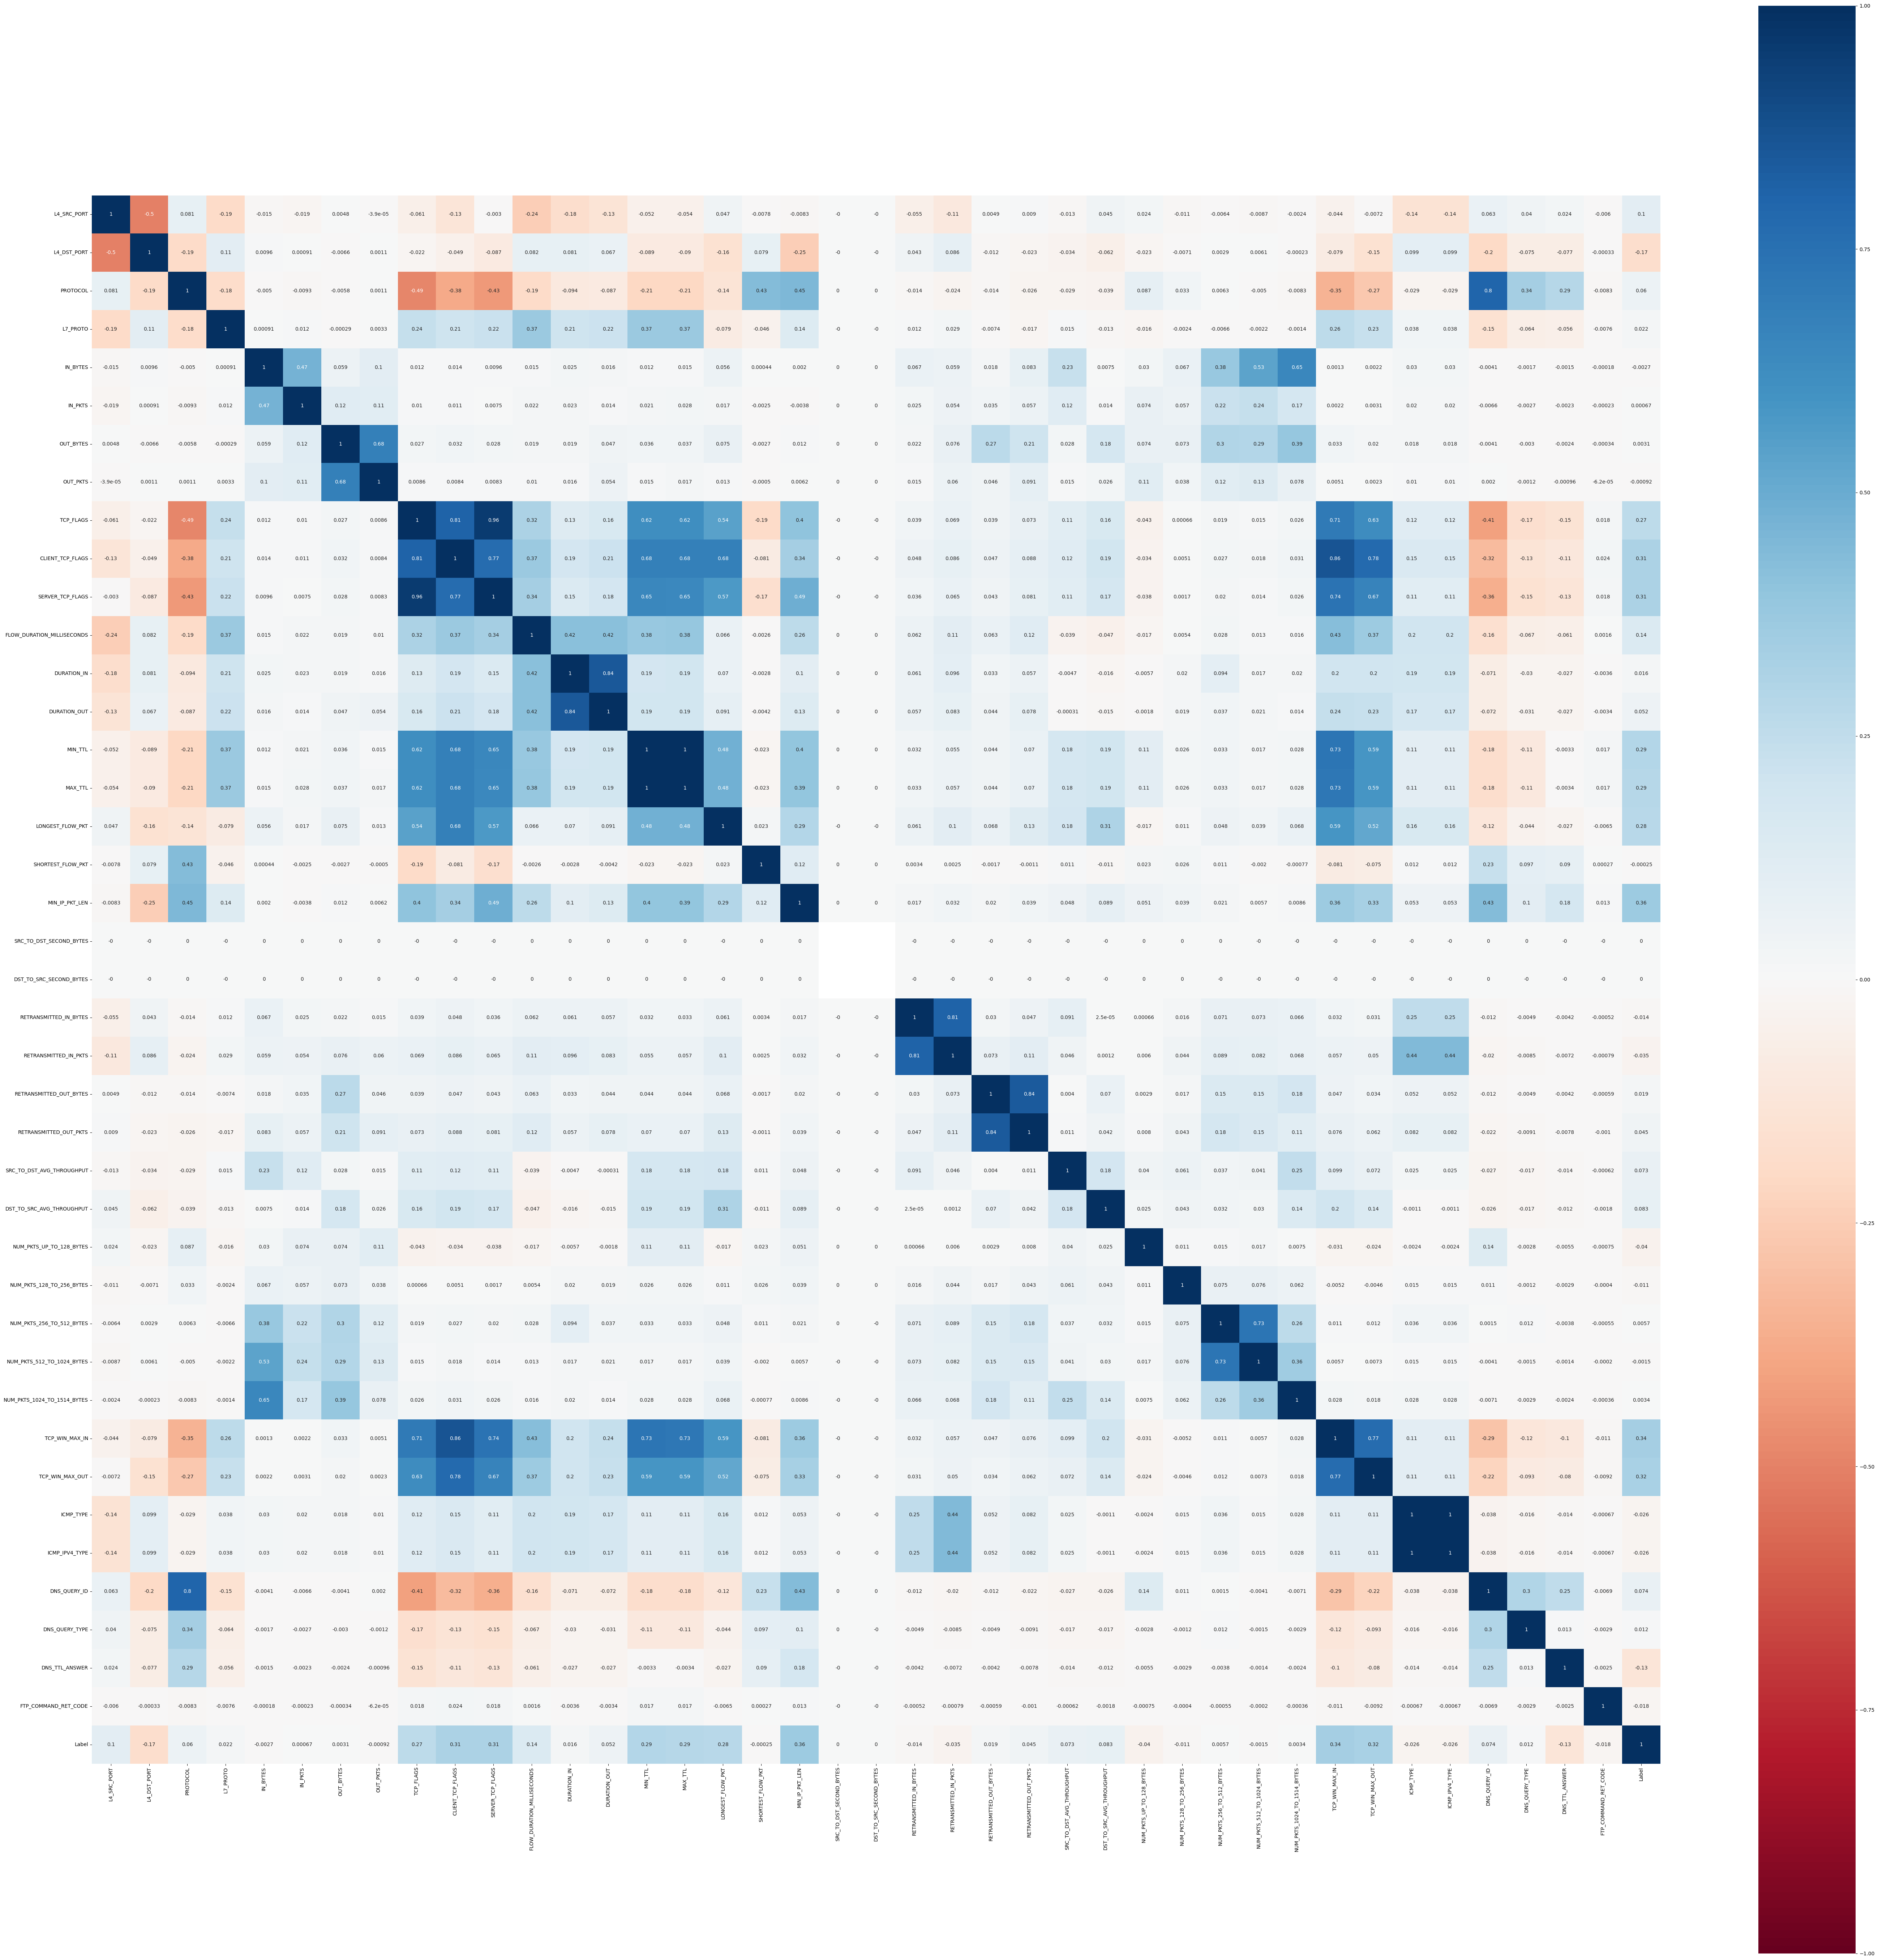

CPU times: user 9.2 s, sys: 946 ms, total: 10.1 s
Wall time: 10.3 s


In [38]:
%%time
# pearson correlation heatmap
plt.figure(figsize=(70, 70))
corr = df_balanced.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, vmax=1, square=True) # annot=True
plt.show()

In [39]:
%%time
correlated_col = set()
is_correlated = [True] * len(corr.columns)
threshold = 0.90
for i in range (len(corr.columns)):
    if(is_correlated[i]):
        for j in range(i):
          if (corr.iloc[i, j] >= threshold) and (is_correlated[j]):
            colname = corr.columns[j]
            is_correlated[j]=False
            correlated_col.add(colname)

print(correlated_col)
print(len(correlated_col))

{'TCP_FLAGS', 'MIN_TTL', 'ICMP_TYPE'}
3
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 19.9 ms


In [40]:
%%time
df_balanced.drop(correlated_col, axis=1, inplace=True)
print (df_balanced.shape)

(722130, 39)
CPU times: user 58.1 ms, sys: 0 ns, total: 58.1 ms
Wall time: 57.8 ms


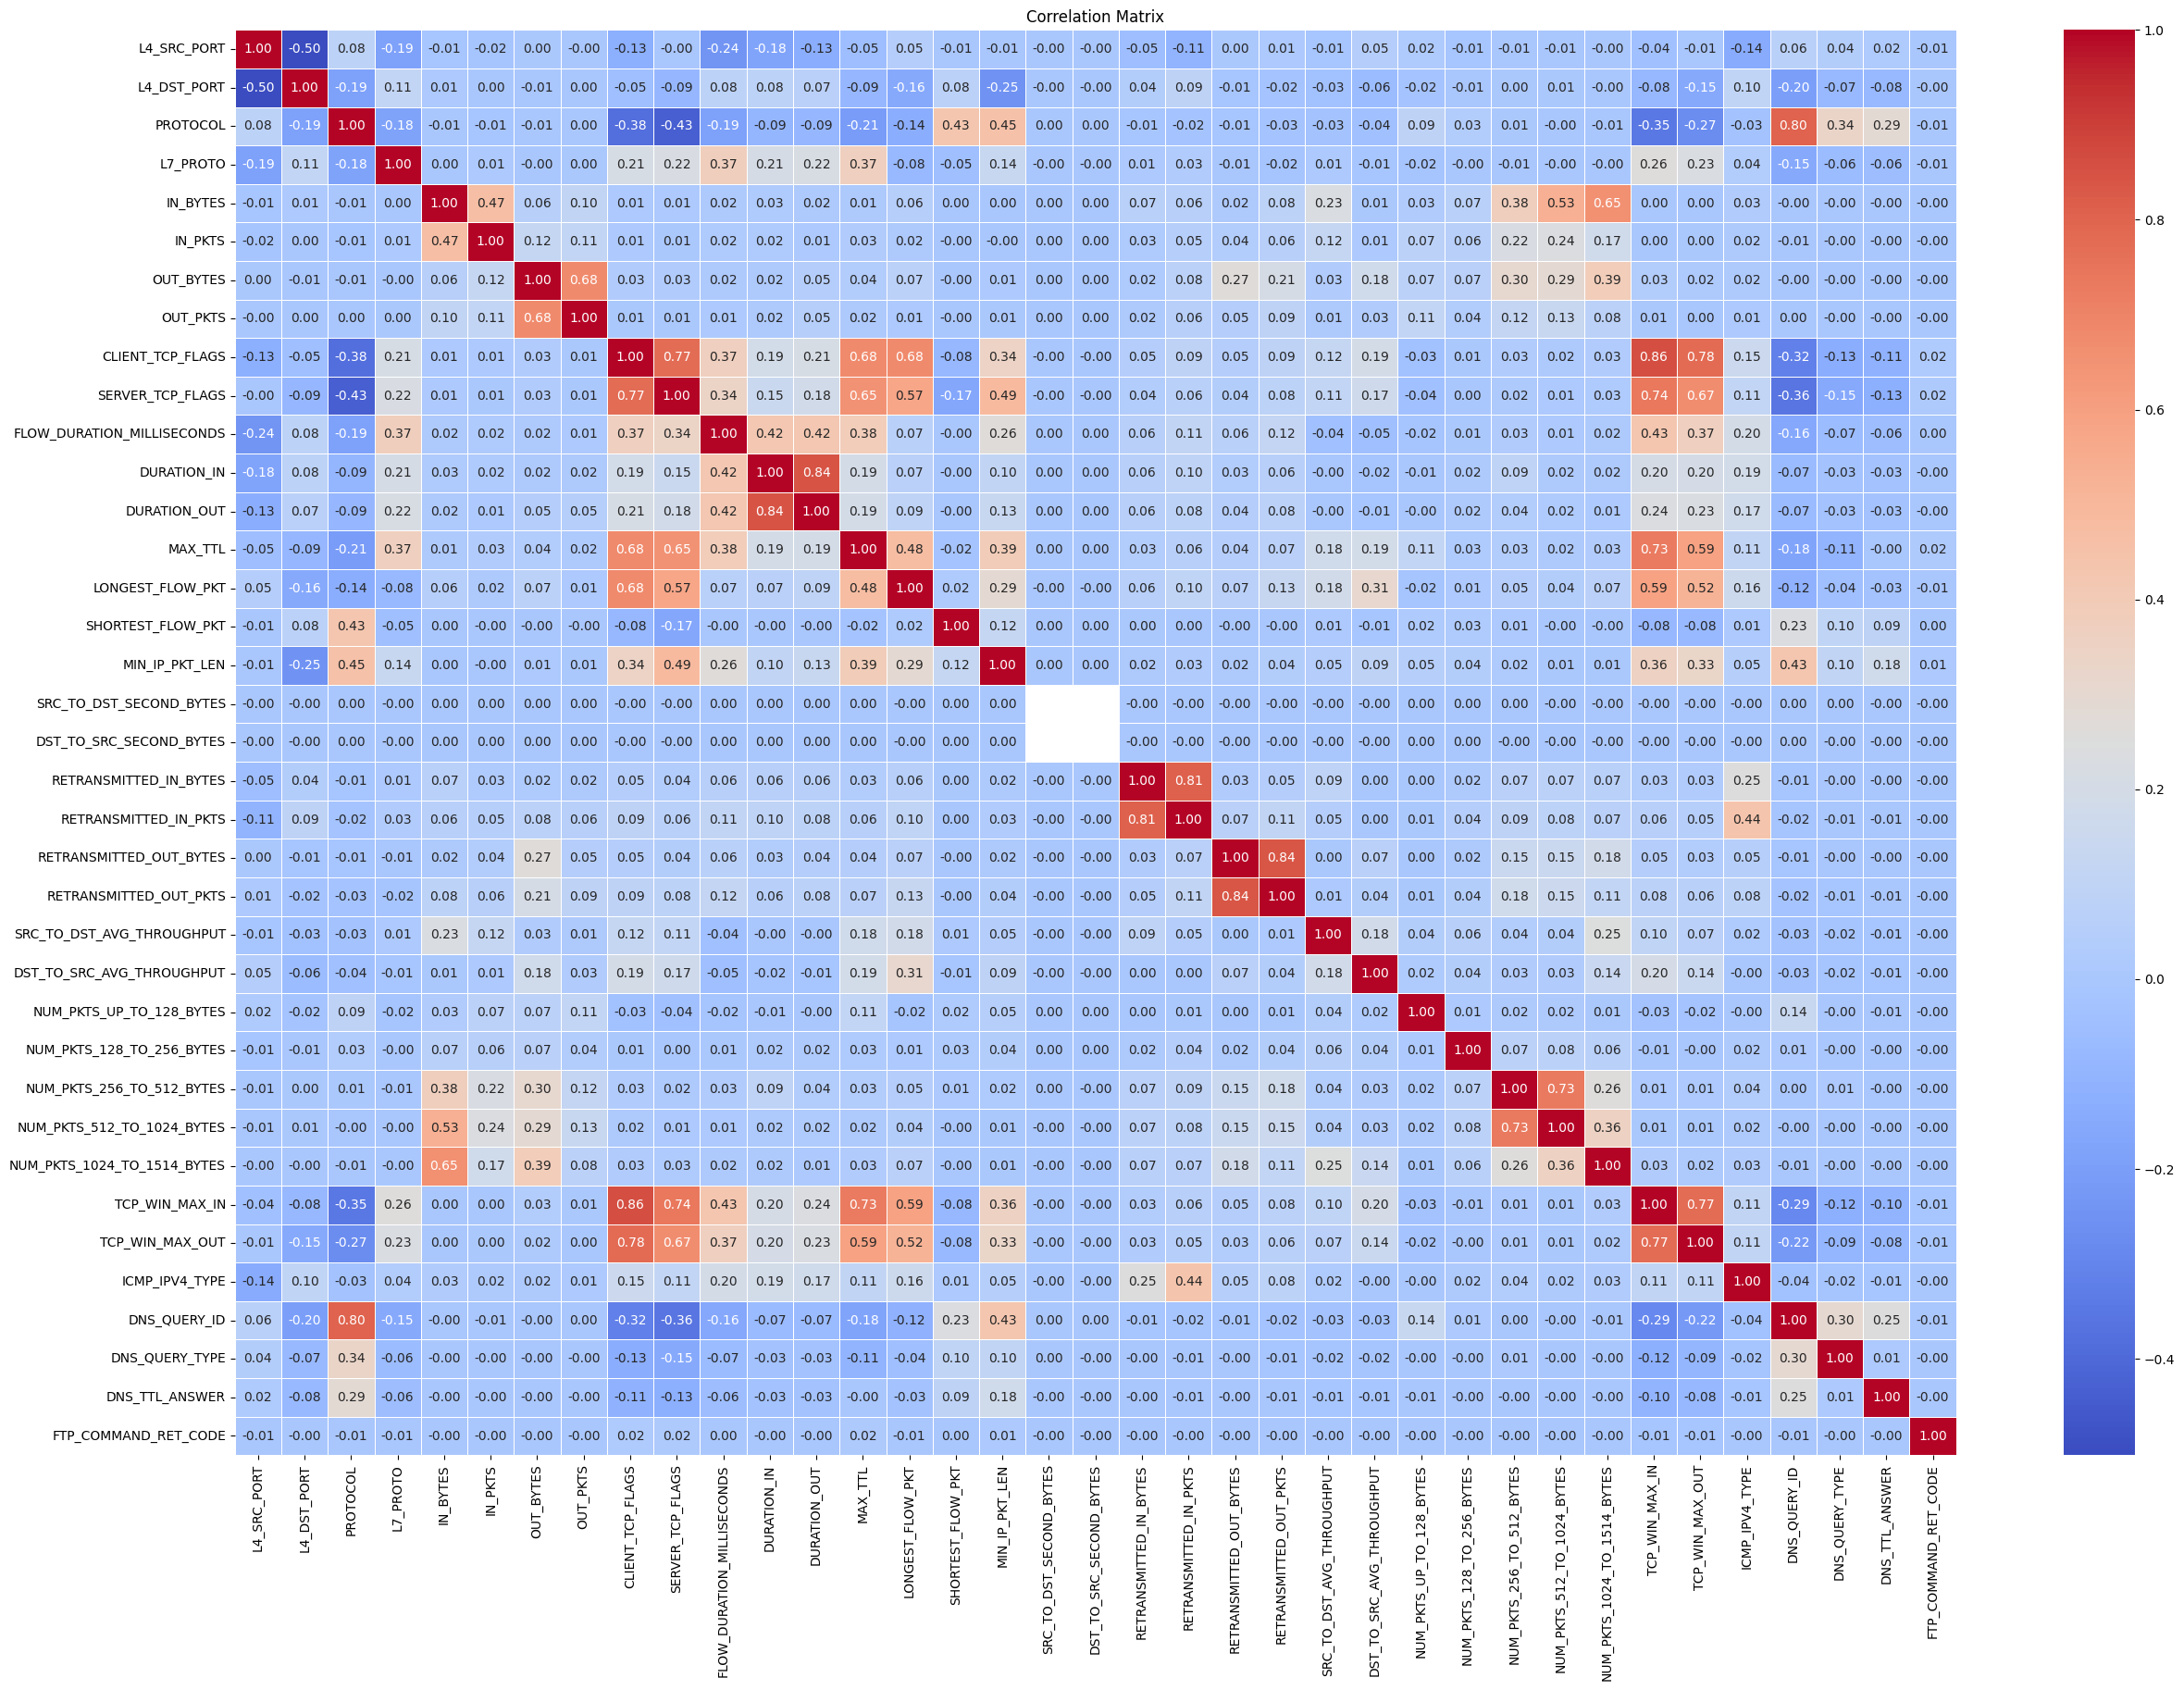

In [41]:
# Calculate correlation matrix
correlation_matrix = df_balanced.drop(['Label', 'Attack'], axis=1).corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1259: RuntimeWarning: overflow encountered in square
  adjusted2 = adjusted**2
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


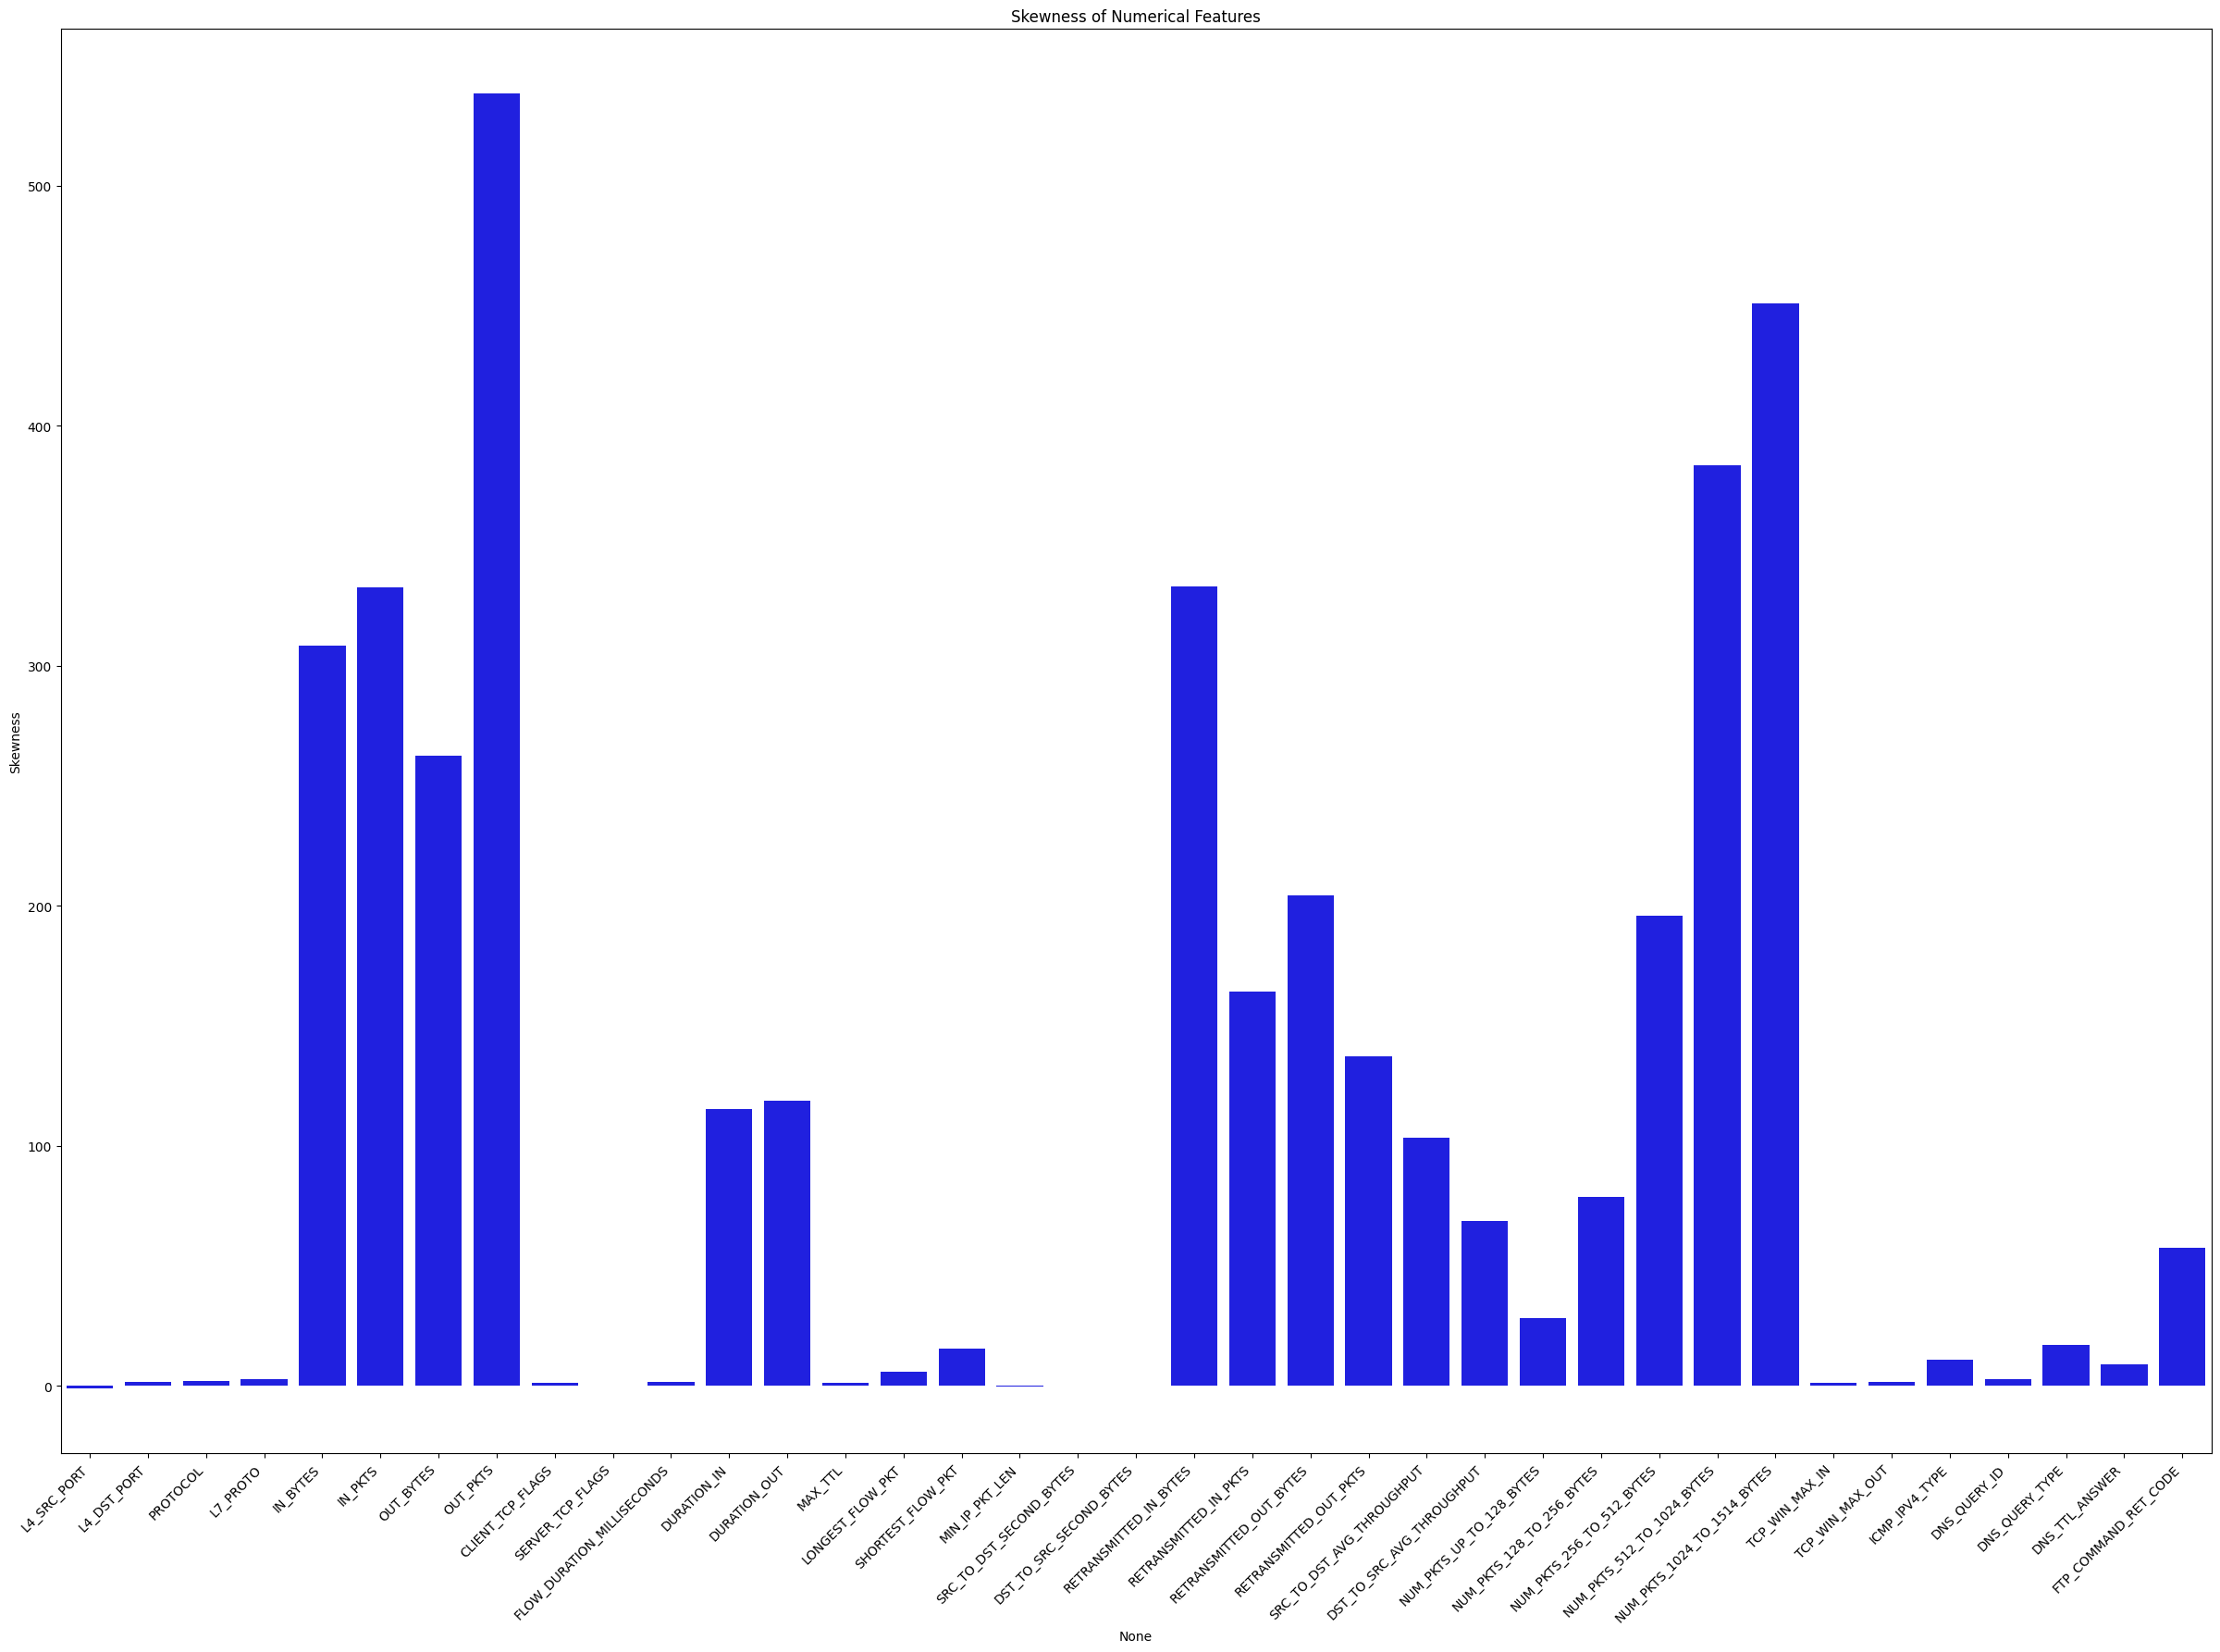

In [42]:
# Calculate skewness for each numerical column
skewness = df_balanced.drop(['Label', 'Attack'], axis=1).skew()

# Create a bar plot or a histogram of skewness values
plt.figure(figsize=(30, 20))
sns.barplot(x=skewness.index, y=skewness.values, color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Skewness of Numerical Features')
plt.ylabel('Skewness')
plt.show()

In [43]:
%%time
df_balanced = df_balanced.drop(["Attack"], axis=1)
X=df_balanced.drop(["Label"], axis=1)
y=df_balanced["Label"]

# split the data for evaluation
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state =42, shuffle=True)

CPU times: user 406 ms, sys: 42.5 ms, total: 448 ms
Wall time: 440 ms


In [44]:
x_train

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,...,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE
10690567,57558,80,6,7.000000,276,5,180,3,18,18,...,0,0,0,29200,5792,0,0,0,0,0
9799340,39512,80,6,7.000000,164,3,112,2,18,19,...,0,0,0,29200,28960,0,0,0,0,0
5148734,48154,995,6,91.230003,410,6,1962,5,30,26,...,0,0,1,29200,28960,0,0,0,0,0
5012633,18243,31510,6,0.000000,48,1,0,0,2,0,...,0,0,0,4096,0,0,0,0,0,0
2514166,29534,56757,6,0.000000,48,1,0,0,2,0,...,0,0,0,4096,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12201615,53208,443,6,91.000000,276,5,224,4,18,19,...,0,0,0,29200,28960,0,0,0,0,0
5284480,44786,443,6,0.000000,1023,7,2200,4,30,26,...,3,1,1,29200,65535,0,0,0,0,0
6441693,40767,53,17,0.000000,65,1,81,1,0,0,...,0,0,0,0,0,0,59283,1,2583,0
12192287,443,34552,6,91.000000,172,3,276,5,19,18,...,0,0,0,28960,29200,0,0,0,0,0


In [45]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training set
x_train = scaler.fit_transform(x_train)

# Transform the testing set using the same scaler
x_test = scaler.transform(x_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1120: RuntimeWarning: overflow encountered in square
  temp **= 2
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


In [46]:
# Random Forest with GridSearchCV
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_model = RandomForestClassifier()
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='accuracy')
rf_grid.fit(x_train, y_train)
rf_best_model = rf_grid.best_estimator_

In [47]:
print("\nBest Estimator's Hyperparameters:")
print(rf_best_model.get_params())


Best Estimator's Hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [52]:
# XGBoost with GridSearchCV
xgb_params = {'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
xgb_model = XGBClassifier()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target variable
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='accuracy')
xgb_grid.fit(x_train, y_train_encoded)
xgb_best_model = xgb_grid.best_estimator_

In [53]:
print("\nBest Estimator's Hyperparameters:")
print(xgb_best_model.get_params())


Best Estimator's Hyperparameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


# **Calculate the Metrics for Random Forest**

In [48]:
# Make predictions on the test set using the best Random Forest model
y_pred_rf = rf_best_model.predict(x_test)
y_proba_rf = rf_best_model.predict_proba(x_test)[:, 1] # Get probabilities for the positive class (class 1)

In [49]:
# Calculate and print the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Random Forest:")
print(conf_matrix_rf)

Confusion Matrix for Random Forest:
[[71439   696]
 [  355 71936]]


In [50]:
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_proba_rf))

ROC AUC Score:
0.9993182363690534



Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     72135
           1       0.99      1.00      0.99     72291

    accuracy                           0.99    144426
   macro avg       0.99      0.99      0.99    144426
weighted avg       0.99      0.99      0.99    144426



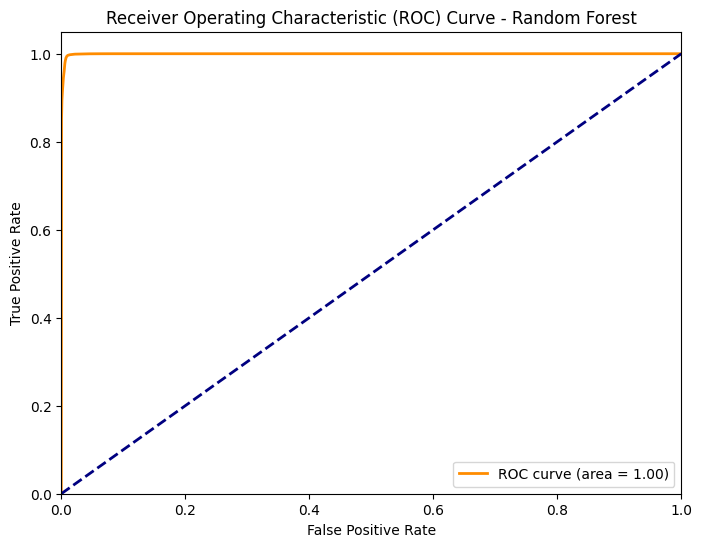

In [51]:
# Calculate and print the classification report
class_report_rf = classification_report(y_test, y_pred_rf)
print("\nClassification Report for Random Forest:")
print(class_report_rf)

# Calculate the ROC curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

# **Calculate the Metrics for XGBoost**

In [54]:
# Make predictions on the test set using the best Random Forest model
y_pred_xgb = xgb_best_model.predict(x_test)
y_proba_xgb = xgb_best_model.predict_proba(x_test)[:, 1] # Get probabilities for the positive class (class 1)

In [55]:
# Calculate and print the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix for XGBoost:")
print(conf_matrix_xgb)

Confusion Matrix for XGBoost:
[[71298   837]
 [  527 71764]]


In [56]:
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_proba_xgb))

ROC AUC Score:
0.9992474084785309



Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     72135
           1       0.99      0.99      0.99     72291

    accuracy                           0.99    144426
   macro avg       0.99      0.99      0.99    144426
weighted avg       0.99      0.99      0.99    144426



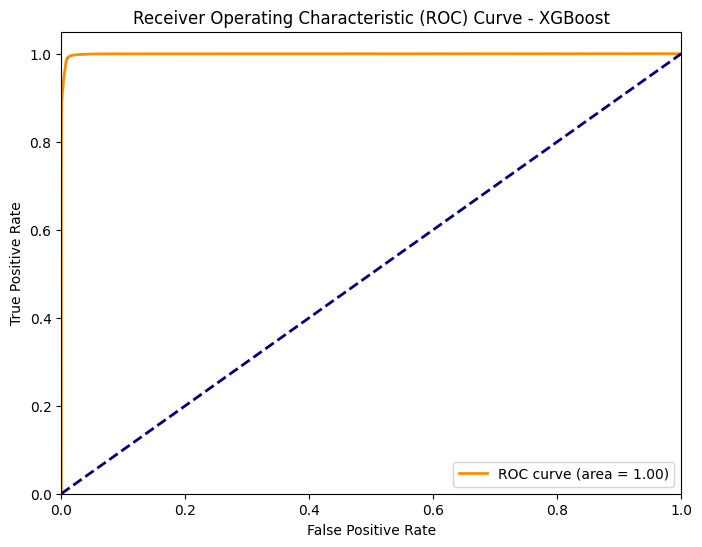

In [57]:
# Calculate and print the classification report
class_report_xgb = classification_report(y_test, y_pred_xgb)
print("\nClassification Report for XGBoost:")
print(class_report_xgb)

# Calculate the ROC curve and AUC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

# **Explainable AI**

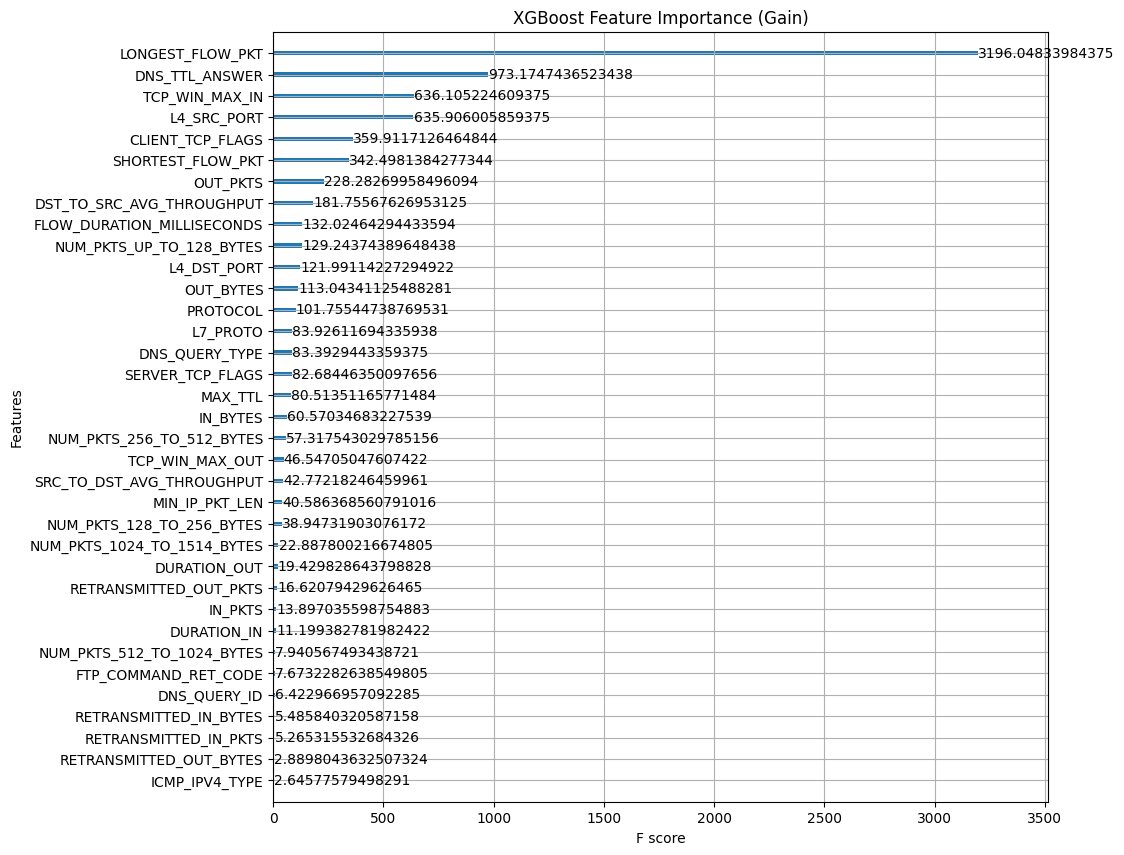

In [58]:
# Plot the feature importance for the best XGBoost model
# You can choose the importance type: 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
# 'gain' is generally recommended as it represents the average gain of splits that use the feature
#ax = xgb_best_model.get_booster().plot_importance(importance_type='gain')
import xgboost as xgb
# Get the feature names from the original DataFrame before splitting
feature_names = df_balanced.columns
ax = xgb.plot_importance(xgb_best_model.get_booster(), importance_type='gain')

# Manually set the y-tick labels to the actual feature names
# The y-ticks correspond to the sorted feature importances, so we need to get the features in that order
sorted_importance = xgb_best_model.get_booster().get_score(importance_type='gain')
sorted_features = sorted(sorted_importance, key=sorted_importance.get)
ax.set_yticklabels([feature_names[int(f.replace('f', ''))] for f in sorted_features])

# Set the figure size for better visualization
fig = ax.figure
fig.set_size_inches(10, 10)

# Set a title
ax.set_title("XGBoost Feature Importance (Gain)")

plt.show()